# コーヒーの飲み頃予報

## 関数定義

In [20]:
! pip install numpy scipy matplotlib japanize_matplotlib
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import japanize_matplotlib

def M(xa, dt=1.0, r=0.002):
    """
    状態遷移関数: 現在の状態から次の状態を予測
    xa: 状態ベクトル [温度, 温度変化率, 室温]
    dt: 時間ステップ (デフォルト1秒)
    r: 熱伝達係数
    """
    l_M = np.array([
        [1, dt, 0],     # 温度 = 現在温度 + 温度変化率×dt
        [-r, 0, r],     # 温度変化率の更新（ニュートンの冷却則）
        [0, 0, 1]       # 室温は一定
    ])
    return l_M @ xa

def jacobianM(funcM, xa):
    """
    状態遷移関数のヤコビ行列を数値的に計算。
    funcM: 状態遷移関数
    xa: 状態ベクトル
    数値微分により各要素の偏微分を計算
    """
    delta = 1e-6  # 数値微分の刻み幅
    n = xa.shape[0]
    jacobian = np.zeros((n, n))
    
    f = funcM(xa)
    for i in range(n):
        x_plus = xa.copy()
        x_plus[i] += delta
        f_plus = funcM(x_plus)
        a = ((f_plus - f) / (delta))
        jacobian[:, i] = a.flatten()
    return jacobian

def MPM(Pa, jacobianM, xa):
    """
    誤差共分散行列の時間発展を計算
    Pa: 現在の誤差共分散行列
    jacobianM: ヤコビ行列計算関数
    xa: 状態ベクトル
    """
    jM = jacobianM(M, xa)  # ヤコビ行列の計算
    return jM @ Pa @ jM.T  # 線形化したシステムでの誤差伝搬


def forcast2tp(xa, pa, target_temp, target_probability, hightemp=True):
    """
    コーヒーの温度予報を行う関数
    
    Parameters:
    xa: 現在の状態ベクトル [温度, 温度変化率, 室温]
    pa: 現在の誤差共分散行列
    target_temp: 目標温度 (℃)
    target_probability: 目標確率
    hightemp: True=温度が下がる予報、False=温度が上がる予報
    """
    global i, log_t # グローバル変数を使っており行儀悪い。
    xf = xa.copy()  # 状態ベクトルのコピー
    pf = Pa.copy()  # 誤差共分散行列のコピー
    i0 = i
    
    # 予報計算ループ
    for i in range(i,100000):
        # 状態と誤差の時間発展
        pf = MPM(pf, jacobianM, xf)  # 誤差共分散行列の更新
        xf = M(xf)  # 状態の更新
        
        # 予報値の計算
        t_forcast = xf[0, 0]  # 予報温度
        sigma = pf[0,0]**0.5  # 標準偏差
        # 目標温度における確率密度を計算
        pdf = stats.norm.pdf(x=target_temp, loc=t_forcast, scale=sigma)

        # 予報結果のログを記録
        log_i = np.hstack((i,t_forcast, sigma,pdf))
        log_t = np.vstack((log_t, log_i)) if log_t.size else log_i.reshape(-1, 4)
        
        # 目標確率に達したかチェック
        if pdf > target_probability:
            if hightemp:
                print(f"現予報モデルにおいて、{target_probability*100}%の確率で、{i}秒には{target_temp}℃を下回る予報です。")
            else:
                print(f"現予報モデルにおいて、{target_probability*100}%の確率で、{i}秒以内に{target_temp}℃を下回る予報です。急いで飲んで")
            return xf, pf

def update(xf, Pf, yo, H, R):
    """
    カルマンフィルタの更新ステップ
    
    Parameters:
    -----------
    xf : 予報状態ベクトル
    Pf : 予報誤差共分散行列
    yo : 観測値
    H : 観測演算子
    R : 観測誤差共分散行列
    
    Returns:
    --------
    xf_updated : 解析状態ベクトル (更新後の状態推定値)
    Pf_updated : 解析誤差共分散行列 (更新後の誤差共分散)
    """
    # カルマンゲインの計算
    S = H @ Pf @ H.T + R  # イノベーション共分散
    K = Pf @ H.T /S       # カルマンゲイン
    K = K.reshape(K.shape[0], -1)  # Kを2次元配列に整形

    # 状態推定値の更新
    y_tilde = yo - H @ xf  # イノベーション（観測値と予報値の差）
    xf_updated = xf + K @ y_tilde.reshape(-1, 1)  # 解析値の計算

    # 誤差共分散行列の更新
    Pf_updated = (np.eye(Pf.shape[0]) - K @ H.reshape(1, -1)) @ Pf

    return xf_updated, Pf_updated

def plot_forecast(log_t, target_temp=70, target_probability=0.05):
    # Create a figure with 2 subplots vertically aligned
    fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

    # Top subplot: Forecasted temperature and confidence interval
    # Plot the forecasted temperature line
    axs[0].plot(log_t[:, 0], log_t[:, 1], label='予報温度', color='blue')
    
    # Calculate confidence interval based on target probability
    sigma_level = norm.ppf(1 - target_probability)  # Convert probability to sigma level
    # Add confidence interval as shaded area
    axs[0].fill_between(log_t[:, 0],  # x values (time)
                        log_t[:, 1] - sigma_level * log_t[:, 2],  # lower bound
                        log_t[:, 1] + sigma_level * log_t[:, 2],  # upper bound
                        color='blue', alpha=0.3, label=f'{sigma_level:.2f}σ範囲')
    
    # Add target temperature line
    axs[0].axhline(y=target_temp, color='green', linestyle='--', label='ターゲット温度')
    # Mark the final prediction point
    axs[0].plot(log_t[-1,0], log_t[-1,1], 'bo')
    # Add time label at the final point
    axs[0].text(log_t[-1,0]*1.04, log_t[-1,1]+ sigma_level * log_t[-1, 2], 
                f"{log_t[-1,0]}秒", va='center', backgroundcolor='white')
    
    # Configure top subplot
    axs[0].set_ylabel(r'コーヒーの予報温度 [℃]')
    axs[0].set_title(r'コーヒーの予報温度の変化')
    axs[0].set_ylim(50, 100)
    axs[0].legend()
    axs[0].grid()

    # Bottom subplot: Probability of reaching target temperature
    # Plot probability line (converted to percentage)
    axs[1].plot(log_t[:, 0], log_t[:, 3] * 100, 
                label='ターゲット温度に到達する確率', color='red')
    # Add target probability line
    axs[1].axhline(y=5, color='blue', linestyle='--', 
                   label=f'{target_probability*100}% 確率ライン')
    
    # Configure bottom subplot
    axs[1].set_xlabel('time [s]')
    axs[1].set_ylabel('確率 [%]')
    axs[1].set_title('ターゲット温度に到達する確率')
    axs[1].set_ylim(-0.5, 8)
    axs[1].legend()
    axs[1].grid()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    return fig, axs



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## コーヒー予報

### 初回予報

現予報モデルにおいて、5.0%の確率で、144秒には70℃を下回る予報です。


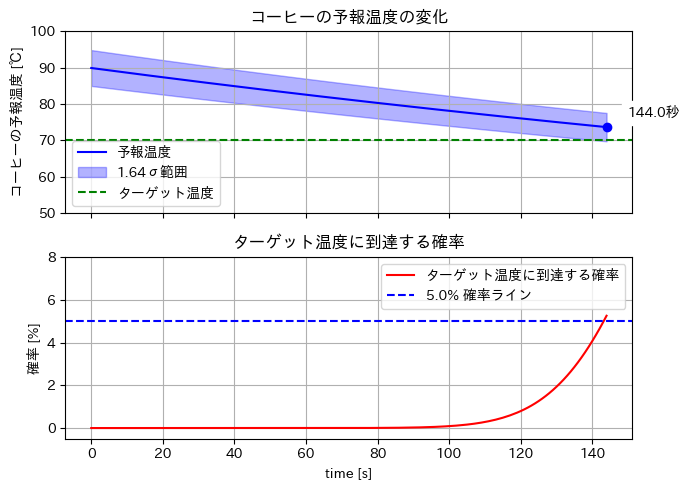

In [ ]:
xa = np.array([90, -0.1, 25]).reshape(3, -1)
Pa = np.array([[9,0.0, 0],[0.01,0.01,0],[0, 0, 9.0]])

H = np.array([[1, 0, 0]])  # 観測演算子
R = np.array([[1]])  # 観測誤差共分散行列
target_temp = 70
target_probability = 0.05

i=0
log_t = np.empty((4,0))

xf, Pf = forcast2tp(xa, Pa, target_temp, target_probability)
fig, axs = plot_forecast(log_t)
#fig.savefig(f'forecast_temperature{i}.svg', dpi=300)

### 2回目予報

現予報モデルにおいて、5.0%の確率で、217秒には70℃を下回る予報です。


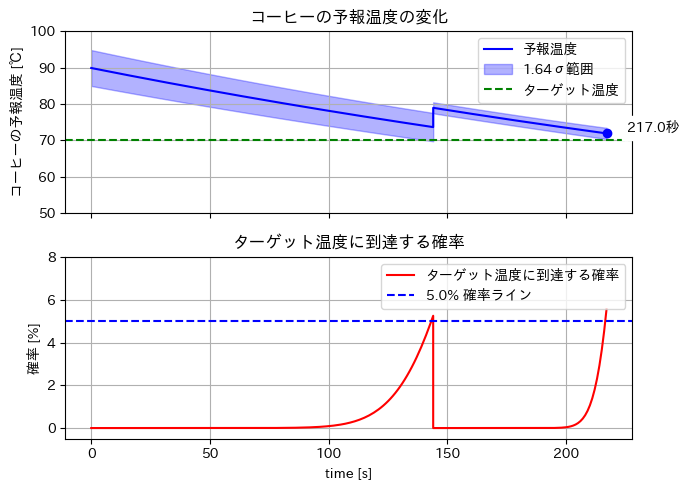

In [ ]:
yo = np.array([80])
xa, Pa = update(xf, Pf, yo, H, R)
xf, Pf = forcast2tp(xa, Pa, target_temp, target_probability)
fig, axs = plot_forecast(log_t)
#fig.savefig(f'forecast_temperature{i}.svg', dpi=300)

### 3回目予報

現予報モデルにおいて、5.0%の確率で、237秒には70℃を下回る予報です。


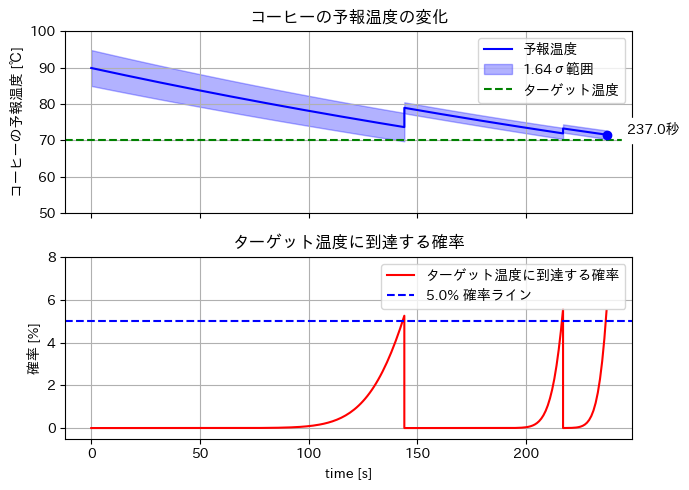

In [ ]:
yo = np.array([75])
xa, Pa = update(xf, Pf, yo, H, R)
xf, Pf = forcast2tp(xa, Pa, target_temp, target_probability)
fig, axs = plot_forecast(log_t)
#fig.savefig(f'forecast_temperature{i}.svg', dpi=300)

### 4回目予報

現予報モデルにおいて、5.0%の確率で、352秒以内に60℃を下回る予報です。急いで飲んで


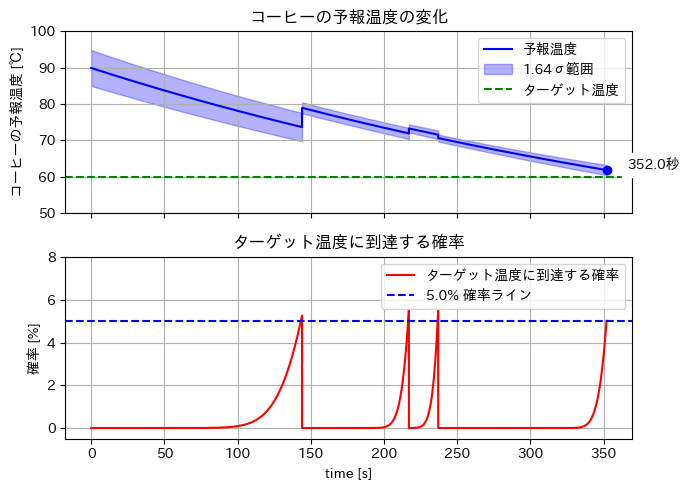

In [ ]:
yo = np.array([69])
target_temp = 60
xa, Pa = update(xf, Pf, yo, H, R)
xf, Pf = forcast2tp(xa, Pa, target_temp, target_probability, hightemp=False)
fig, axs = plot_forecast(log_t, target_temp=target_temp)
#fig.savefig(f'forecast_temperature{i}.svg', dpi=300)